In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
import re
from glob import glob
import iminuit
import probfit as pf

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

/home/petrov/.local/lib/python3.7/site-packages/mplhep/__init__.py:48: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [326]:
class MDVM():
    ALPHA = 7.297353e-3
    PI = np.pi
    C = 0.3893794e6 #Gev^2*nb
    M_KN = 0.497611 #GeV
    M_KC = 0.493677 #GeV
    M_PN = 0.134977 #GeV
    M_PC = 0.139571 #GeV
    M_RHO = 0.77526 #Gev
    W0_RHO = 0.1491 #GeV
    M_OMG = 0.78265 #GeV
    W0_OMG = 0.00849 #GeV
    M_PHI = 1.019461 #GeV
    W0_PHI = 0.00425 #GeV
    
    
    def Beta(e, charged):
        s = e**2
        M = MDVM.M_KC if charged else MDVM.M_KN
        return np.where( e>2*M, np.sqrt(1-4*(M**2)/s), 0)
    def Eta(e, eta0=1.027):
        M_PHI, W_PHI = MDVM.M_PHI, MDVM.W0_PHI
        return np.where((e>(M_PHI - W_PHI))&(e<(M_PHI + W_PHI)), eta0, 1)
    
    def W_const(s, M, W0):
        '''constant dependence only'''
        return W0
    def W_2(s, M0, W0, M_Decay):
        return W0*np.sqrt((s - M_Decay**2)/(M0**2 - M_Decay**2))**3
    def W_Rho770(s, M0, W0):
        return MDVM.W_2(s, M0, W0, MDVM.M_PC)
    def W_Phi1020(s, M, W0):
        Br_KpKm = 0.492
        Br_KsKl = 0.34
        Br_3pi  = 0.1524
        Br_EtaG = 0.01303
        Br_Left = 1 - Br_KpKm - Br_KsKl - Br_3pi - Br_EtaG
        W = ( (Br_KpKm + Br_Left)*MDVM.W_2(s, M, W0, MDVM.M_KC) + Br_KsKl*MDVM.W_2(s, M, W0, MDVM.M_KN) + \
              Br_3pi * MDVM.W_const(s, M, W0) + Br_EtaG*MDVM.W_const(s, M, W0) )
        return W        
    def BW(e, M, W0, W):
        s = e**2
        return (M**2)/( M**2 - s - 1j*M*W(s, M, W0) )  #Bruch: 1j*e*W(s, W0) <-> SND: 1j*M*W(s, W0)
    def BW_R(e, M, W0):
        return MDVM.BW(e, M, W0, MDVM.W_Rho770)       
    def BW_O(e, M, W0):
        return MDVM.BW(e, M, W0, MDVM.W_const)       
    def BW_P(e, M, W0):
        return MDVM.BW(e, M, W0, MDVM.W_Phi1020)
    def Formfactor2(e, par=[], charged=True):
        '''Returns absolute formfactor in square'''
#         KR = np.array([1.067, -0.025, -0.234, 0.063])
#         KO = np.array([1.28, -0.13, -0.234, 0.063])
#         KP = np.array([1.038, -0.15, 0.089])
        KR = np.array([1.139, -0.124, -0.015, 0.])
        KO = np.array([1.467, -0.018, -0.449, 0.])
        KP = np.array([0.999, 0.001, 0.])
        Eta0 = 1.027
        if (len(par)>5):
            KR = np.array([par[0], par[1], par[2], par[3]])
            KO = np.array([par[4], par[5], par[6], par[3]])
            KP = np.array([par[7], par[8], par[9]])
            Eta0 = par[10]
            
        ETA = 1 if charged else MDVM.Eta(e, Eta0)
        CR = KR/2 if charged else -KR/2
        CO = KO/6
        CP = KP/3
        
        MR = np.array([MDVM.M_RHO, 1.465, 1.72, 2.15])
        WR = np.array([MDVM.W0_RHO, 0.4, 0.25, 0.343])
        MO = np.array([MDVM.M_OMG, 1.420, 1.67, 2.15])
        WO = np.array([MDVM.W0_OMG, 0.22, 0.315, 0.343])
        MP = np.array([MDVM.M_PHI, 1.68, 2.188])
        WP = np.array([MDVM.W0_PHI, 0.15, 0.083])
        
        FR = CR[0]*MDVM.BW_R(e, MR[0], WR[0]) + CR[1]*MDVM.BW_R(e, MR[1], WR[1]) + CR[2]*MDVM.BW_R(e, MR[2], WR[2])
        FO = CO[0]*MDVM.BW_O(e, MO[0], WO[0]) + CO[1]*MDVM.BW_O(e, MO[1], WO[1]) + CO[2]*MDVM.BW_O(e, MO[2], WO[2])
        FP = CP[0]*MDVM.BW_P(e, MP[0], WP[0])*ETA + CO[1]*MDVM.BW_P(e, MP[1], WP[1]) + CP[2]*MDVM.BW_P(e, MP[2], WP[2])
        
        F = FR + FO + FP
        return np.square( np.abs(F) )
        
    def CrossSection(e, par, charged):
        '''e [GeV], charged [True/False]'''
        s = e**2
        F2 = MDVM.Formfactor2(e, par, charged)
        BETA = MDVM.Beta(e, charged)
        return np.pi*(MDVM.ALPHA**2)*(BETA**3)*F2*MDVM.C/(3*s)        
    def CrossSectionCharged(e, par=[]):
        return MDVM.CrossSection(e, par, charged=True)
    def CrossSectionNeutral(e, par=[]):
        return MDVM.CrossSection(e, par, charged=False)

In [61]:
%cd ../lib

/spoolA/petrov/research/uproot/lib


In [74]:
from lib import get_KSKL_phi, get_KSKL_up, get_KPKM_phi, get_KPKM_up2, get_KPKM_up, plot_cs

In [64]:
#neutral kaons
cs_n = [get_KSKL_phi(), 
        get_KSKL_up('./data/fit_frame_19_rotated.csv', './data/rad_frame_rotated.csv'),
        get_KSKL_up('./data/fit_frame_17_rotated.csv', './data/rad_frame_rotated.csv'),
        get_KSKL_up('./data/fit_frame_12_rotated.csv', './data/rad_frame_v6_rotated.csv'),
        get_KSKL_up('./data/fit_frame_11_rotated.csv', './data/rad_frame_v6_rotated.csv'),
       ] 
#charged kaons
cs_c = [get_KPKM_phi(), get_KPKM_up(), get_KPKM_up2()]

In [337]:
def least_squares(par):
    chisq = 0
    for c in np.array(cs_n):
        chisq += np.sum(np.square( (c.cs - MDVM.CrossSectionNeutral(c.energy, par))/c.cs_err )[c.energy<1.1])
    for c in cs_c:
        chisq += np.sum(np.square( (c.cs - MDVM.CrossSectionCharged(c.energy, par))/c.cs_err )[c.energy<1.1])
    return chisq

In [330]:
params = [1.0171, 0., 0., 0.0, 1.2, 0., 0., 1.0359, 0., 0., 0.9821]
fix_pars = [False, True, True, True, False, True, True, False, True, True, False] # True False
error_pars = 0.001*np.array(params)
len(params), len(fix_pars)

(11, 11)

In [331]:
m = iminuit.Minuit.from_array_func(least_squares, params, fix=fix_pars, \
                                   error=error_pars, errordef=1)#, name=names, limit=limit_pars
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.017   |   0.001   |            |            |         |         |       |
| 1 | x1   |     0     |     0     |            |            |         |         |  yes  |
| 2 | x2   |     0     |     0     |            |            |         |         |  yes  |
| 3 | x3   |     0     |     0     |            |            |         |         |  yes  |
| 4 | x4   |   1.200   |   0.001   |            |            |         |         |       |
| 5 | x5   |     0     |     0     |            |            |         |         |  yes  |
| 6 | x6   |     0     |     0     |            |            |         |         |  yes  |
| 7 | x7   |   1.036   |   0.001   |            |            |         |         |       |
| 8 | x8   |     0     |     0     |            |            |         |         |  yes  |
| 9 | x9   |     0     |     0     |            |            |         |         |  yes  |
| 10| x10  |   0.982   |   0.001   |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [332]:
m.migrad()

------------------------------------------------------------------
| FCN = 4129                    |     Ncalls=117 (117 total)     |
| EDM = 2.43E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   2.328   |   0.016   |            |            |         |         |       |
| 1 | x1   |     0     |     0     |            |            |         |         |  yes  |
| 2 | x2   |     0     |     0     |            |            |         |         |  yes  |
| 3 | x3   |     0     |     0     |            |            |         |         |  yes  |
| 4 | x4   |   2.26    |   0.04    |            |            |         |         |       |
| 5 | x5   |     0     |     0     |            |            |         |         |  yes  |
| 6 | x6   |     0     |     0     |            |            |         |         |  yes  |
| 7 | x7   |   1.011   |   0.002   |            |            |         |         |       |
| 8 | x8   |     0     |     0     |            |            |         |         |  yes  |
| 9 | x9   |     0     |     0     |            |            |         |         |  yes  |
| 10| x10  |   1.015   |   0.004   |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [333]:
print('params =', list(m.np_values().round(4)) )

params = [2.3277, 0.0, 0.0, 0.0, 2.2566, 0.0, 0.0, 1.0106, 0.0, 0.0, 1.0146]


In [334]:
params = m.np_values()

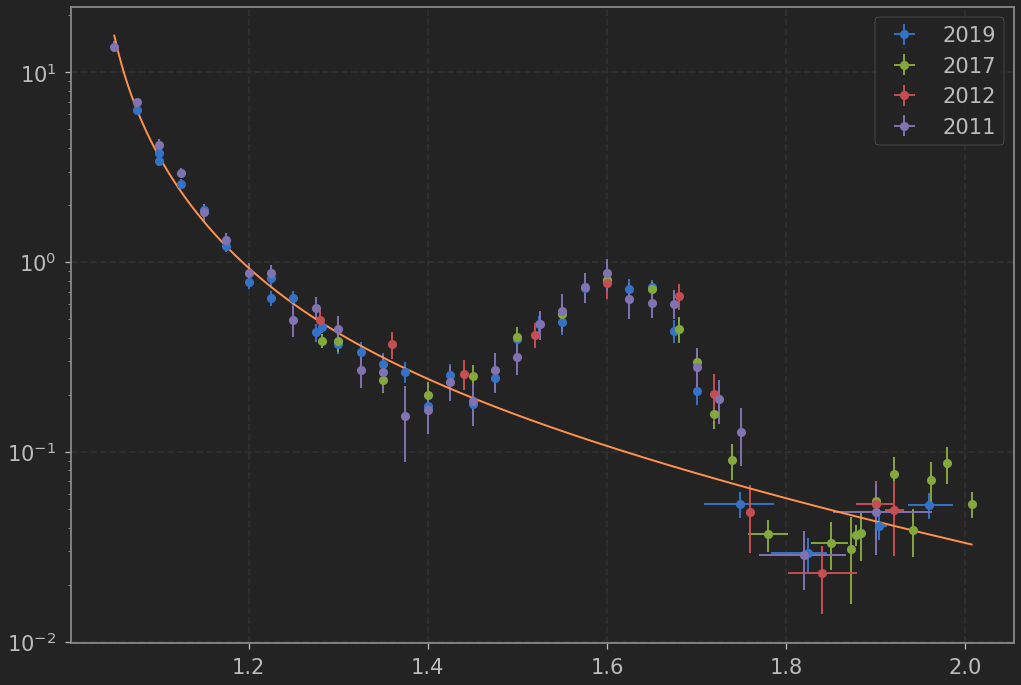

In [335]:
plot_cs(MDVM.CrossSectionNeutral, params, [cs_n[1], cs_n[2], cs_n[3], cs_n[4]], ['2019','2017', '2012', '2011'])

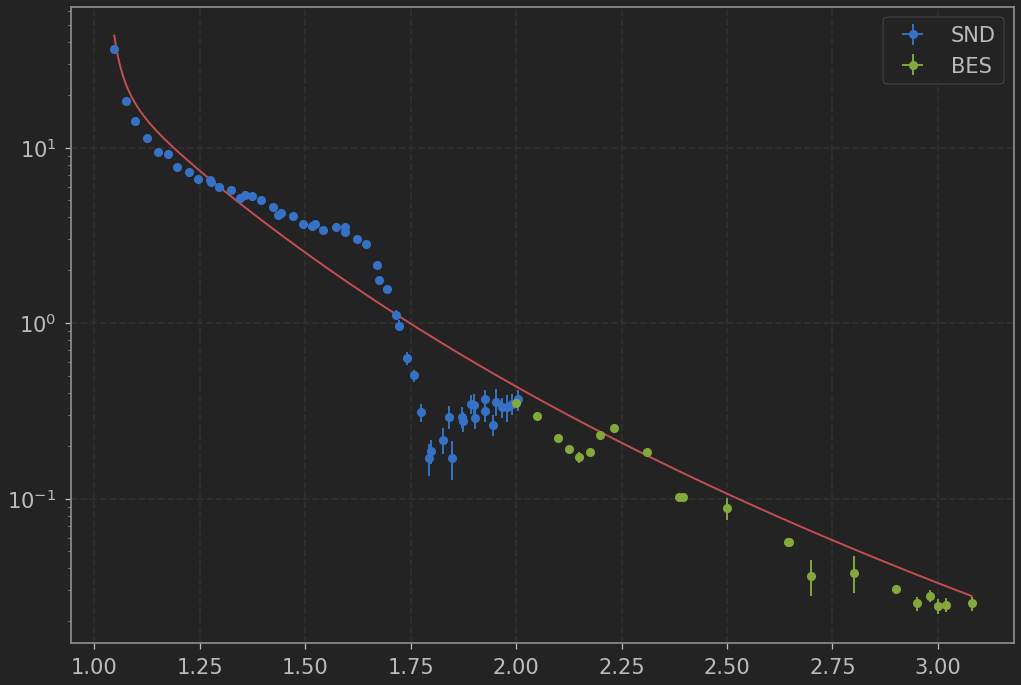

In [336]:
plot_cs(MDVM.CrossSectionCharged, params, [cs_c[1], cs_c[2]], ['SND','BES'])

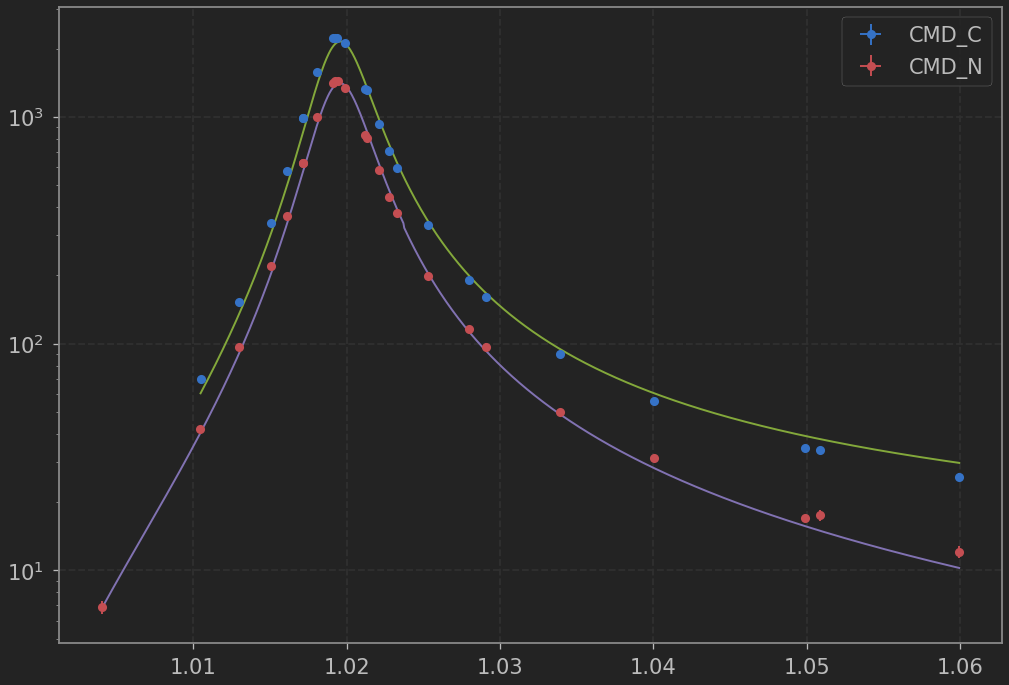

In [338]:
plot_cs(MDVM.CrossSectionCharged, params, [cs_c[0]], ['CMD_C'])
plot_cs(MDVM.CrossSectionNeutral, params, [cs_n[0]], ['CMD_N'])

In [184]:
from ipywidgets import interact
def f(phi):
    pars = params.copy()
    pars[9] = phi
    plot_cs(MDVM.CrossSectionCharged, pars, [cs_c[1], cs_c[2]], ['SND','BES'])
interact(f, phi=(-.01, .01, 1e-4))

interactive(children=(FloatSlider(value=0.0, description='phi', max=0.01, min=-0.01, step=0.0001), Output()), …

<function __main__.f(phi)>

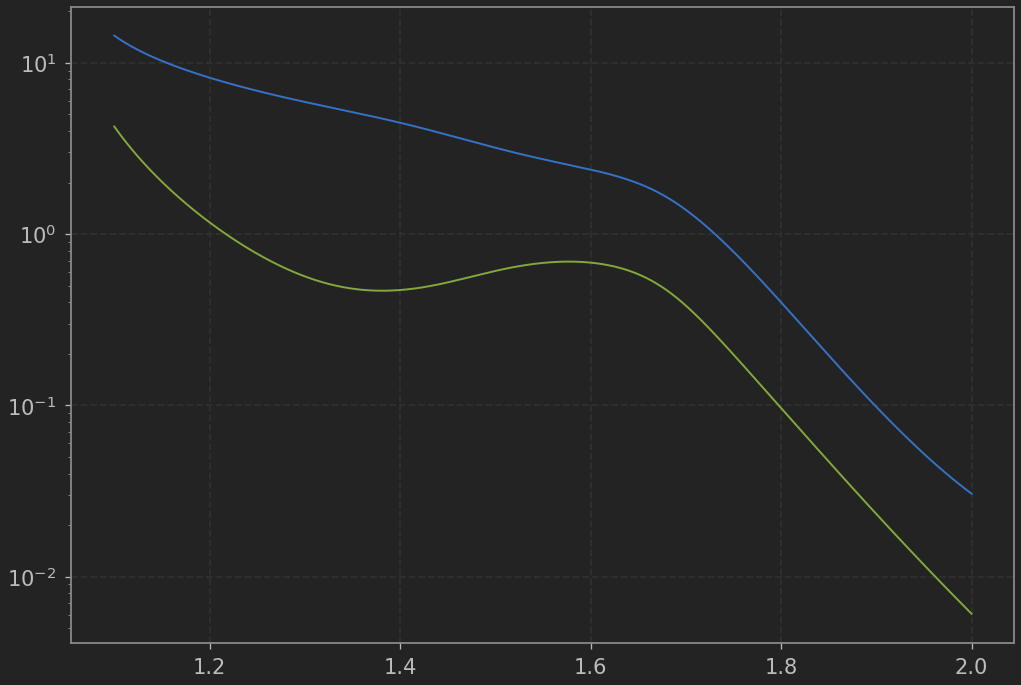

In [79]:
e = np.linspace(1.1, 2., 1000)
plt.plot(e, MDVM.CrossSectionCharged(e))
plt.plot(e, MDVM.CrossSectionNeutral(e))
plt.yscale('log')

In [389]:
from scipy.integrate import quad
def q(M, mi, mj):
    Mm = M**2 - (mi-mj)**2
    Mp = M**2 - (mi+mj)**2
    return np.sqrt( Mm*Mp )/(2*M)
def W_Rho(s):
    return MDVM.W0_RHO
def D_Rho(s):
    m_rho = MDVM.M_RHO
    return m_rho**2 - s - 1j*np.sqrt(s)*MDVM.W_Rho770(s, m_rho, MDVM.W0_RHO)

def W_foo(s, m, x):
    m_pi = MDVM.M_PC
    q_pi = q(m, m_pi, m_pi)
    q_rho = q(np.sqrt(s), m, m_pi )
    f = (q_rho*q_pi)**3
    f = f*(1-x**2)
    print(f)
    m1 = (s - 3*(m_pi**2) - m**2)/2
    m2 = 2*np.sqrt(s)*q_pi*q_rho*x/m
    mm, mp = m1 - m2, m1 + m2
    
    print(mm, mp)
    D = 1/D_Rho(m**2) + 1/D_Rho(mm**2) + 1/D_Rho(mp**2)
    D = np.abs(D)**2
    print(D)
    f = f*D
    print(f)
    return f

In [390]:
W_foo(1.1, 0.7, -1)

0.0
0.5312948953224459 0.020264912554554204
nan
nan


/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


nan

In [366]:
def W1int(s, m):
    return quad(W_foo, -1, 1, args=(s, m))[0]

In [369]:
W1int(1.1, 0.7)

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, whi

nan